## Matchup Analysis of Water Quality Features
This notebook is used to perform the matchup analysis between the in situ measurements and estimations of the water quality parameters (Chl-a/turbidity). The output is a series of diagrams for a single's days measurments, as well as a combination of all dates. Apart from diagrams evaluating the goodness of matchup, a series of diagrams has been created to evaluate the parameters that yield the best matchup (e.g. time difference between in situ and estimations, distance of in situ from perimeter of water body etc.) <br>

### Input Requirements
- **In situ measurements**<br>
    In situ measurements should be placed inside the `data/csv` folder (in the root of the project) with naming convention `Data_WaterBodyName_YYMMDD.csv`. The csv files are created and brought to a uniform format using the notebook `Step1_InSitu_Data_Cleanup_And_Normalization.ipynb` <br><br>
- **Water Quality Feature Estimations**<br>
    The Water Quality Feature Estimations are stored in GeoTiff format (as generated by the Water Quality Features service) and should be placed in the folder `notebooks/data`.<br>
    The Chl-a estimations should end with suffix `_algae_monitor.tif` and turbidity estimations with `_turbidity_monitor.tif`.<br>

Some of the parameters of the matchup analysis can be modified inside the notebook.

First some necessary modules are loaded

In [1]:
# For autoloading of a local module
%load_ext autoreload
%autoreload 2

In [2]:
# For cleaner output
import warnings

# Suppress all runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Suppress all user warnings
warnings.filterwarnings("ignore", category=UserWarning)
# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
import pandas as pd
import geopandas as gpd
from datetime import datetime
import os
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import matchup_utils.sample as sample
from matchup_utils.utils import log_header
from matchup_utils.scatter import ScatterType
from matchup_utils.plot import Plotter
import numpy as np
import rasterio

# Perform analysis for all dates for Polyfytos

Here you can select the dates that will be analysed, the kernel size for the sampling and whether to save the jpg files. Also input and output directories are set.

In [4]:
dates = ['20220930', '20220617', '20250626'] # the dates that will be analyzed
kernel_size = 3 # size of the square around the sampling point (kernel_size x kernel_size)
savejpg = True # Save figures in jpg
savepdf = True # Save figures in pdf

# Set directory
insitu_dir = "./data/" # in situ measurements

# Create folder for outputs
unique_id = datetime.now().strftime("%Y-%m-%d_%H%M%S")
os.makedirs(f"./plots/{unique_id}", exist_ok=True)
fig_dir = f"plots/{unique_id}"

This cell is were sampling happens. In brief:
- In situ data are preprocessed
    - In situ data is loaded and coordinates in degrees decimal minutes are converted to decimal degrees
    - Samples that are located outside the water body perimeter are discarded
    - Some necessary columns for later analysis are computed (e.g. Time (UTC), distance from lake perimeter)
- Rasters (with water quality features) are sampled
    - Rasters (algae and turbidity) with the same date as the in situ measurements are selected
    - Sampling of rasters with a square kernel around each sampling point (this can be parameterized in the above cell)
    - Calculation of mean of the values in each square kernel. This is the estimation of the water quality feature for each sampling point
    - Secondary jobs: computing time difference between in situ and satellite overpass and setting of colors/labels for each sampling point (to differentiate samples of different dates in plots)

Filtering of the samples happens later - if the user chooses to (e.g. removal of outliers, filtering of samples based on time difference from satellite overpass) before plotting, so as to leave flexibility on the plots that will be created.

In [5]:
colors = sns.color_palette('Set2', n_colors=len(dates)) # one color per date
gdfs = []

for i, this_date in enumerate(dates): # For each date

    print(log_header(f'Date: {datetime.strptime(this_date, "%Y%m%d").strftime("%d-%m-%Y")}'))

    # Load in situ data
    df = pd.read_csv(f'../data/csv/Data_Polyphytos_{this_date}.csv')

    # Prepare samples
    gdf = sample.prepare_for_sampling(df=df, lakePolygonPath='../data/geojson/polyfitos_lake.geojson', date=this_date, storeInShape=True, shapeFolder=fig_dir)

    # Sample rasters
    # Chl-a
    sample.sample_raster(gdf=gdf, feature="algae", output_subdir=insitu_dir, date=this_date, kernelSize=kernel_size)
    # turbidity
    sample.sample_raster(gdf=gdf, feature="turbidity", output_subdir=insitu_dir, date=this_date, kernelSize=kernel_size)

    # Set color/label for each sample
    gdf['color'] = len(gdf)*[colors[i]]
    gdf['label'] = len(gdf)*[datetime.strptime(this_date, "%Y%m%d").strftime("%d-%m-%Y")]

    gdfs = gdfs + [gdf]

# Concatenate all GeoDataFrames into one
gdfAll = gpd.pd.concat(gdfs, ignore_index=True)


     Date: 30-09-2022     
⚠️ One or more points were outside the perimeter of the lake (possibly wrong geolocation). They were clipped. ⚠️
➡️ Files to be sampled for algae: ['S2A_MSIL1C_20220930T092041_N0510_R093_T34TEK_20240725T230829_algae_monitor.tif']
Satellite Overpass at: 2022-09-30 09:20:41+00:00 UTC
Image CRS :2100 ~ Geometry CRS 2100
Image CRS :2100 ~ Geometry CRS 2100
➡️ Files to be sampled for turbidity: ['S2A_MSIL1C_20220930T092041_N0510_R093_T34TEK_20240725T230829_turbidity_monitor.tif']
Satellite Overpass at: 2022-09-30 09:20:41+00:00 UTC
Image CRS :2100 ~ Geometry CRS 2100

     Date: 17-06-2022     
⚠️ One or more points were outside the perimeter of the lake (possibly wrong geolocation). They were clipped. ⚠️
➡️ Files to be sampled for algae: ['S2B_MSIL1C_20220617T092029_N0510_R093_T34TEK_20240619T104656_algae_monitor.tif']
Satellite Overpass at: 2022-06-17 09:20:29+00:00 UTC
Image CRS :2100 ~ Geometry CRS 2100
Image CRS :2100 ~ Geometry CRS 2100
➡️ Files to be sampl

# Scatter plots for all dates

Here, filters can be applied to the samples before the plots are created.
The filters are the following:
- Keep samples that were captured only 2 hours after sampling (use the `two_hours` variable)
- Remove outliers manually using filters by adding code to a cell below (use the `remove_outlier` variable)

After filtering the samples are removed from the GeoDataFrame for the analysis and the filters that are applied are also reflected on the names and titles of figures and files.

In [6]:
TIME_DIFF_LIMIT=-1 # Select in situ samples with at most 2 hour difference from satellite overpass
remove_outlier = True # If true, outliers will be manually removed by the following if-clause

Here the outliers are removed. The process is controlled manually (by adding code to the following block) so that each outlier removed is assessed.

In [7]:
gdfPlots = gdfAll.copy()
if remove_outlier:
    gdfPlots.loc[((gdfAll['Turbidity (NTU)']>15.0) & (gdfAll['date']=="2022-06-17")), ['Turbidity (NTU)', 'Turbidity (NTU) Estimation']] = np.nan

This scatter contains removed outliers.
15.06484
This is the basic scatter plot
plots/2025-09-30_144353/polyfytos_scatter_algae_all.jpg


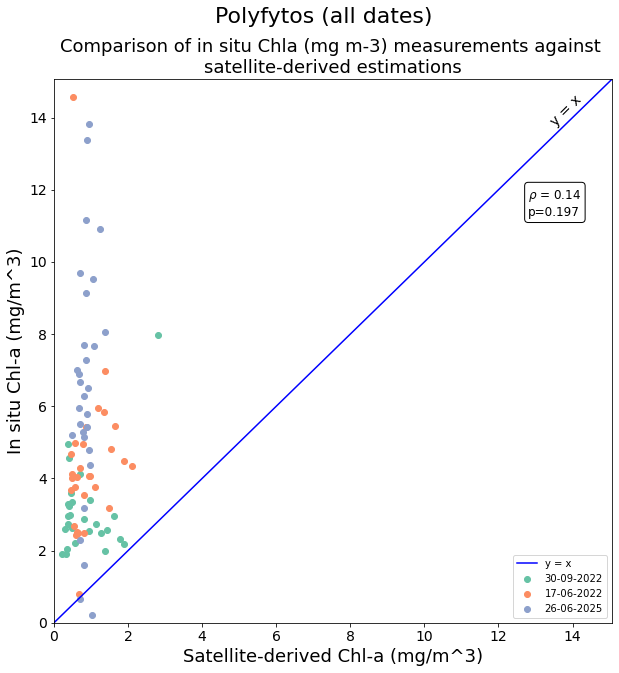

15.06484
This scatter plot color-codes the samples depending on the time difference between in situ measurement and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_algae_all_dtC.jpg


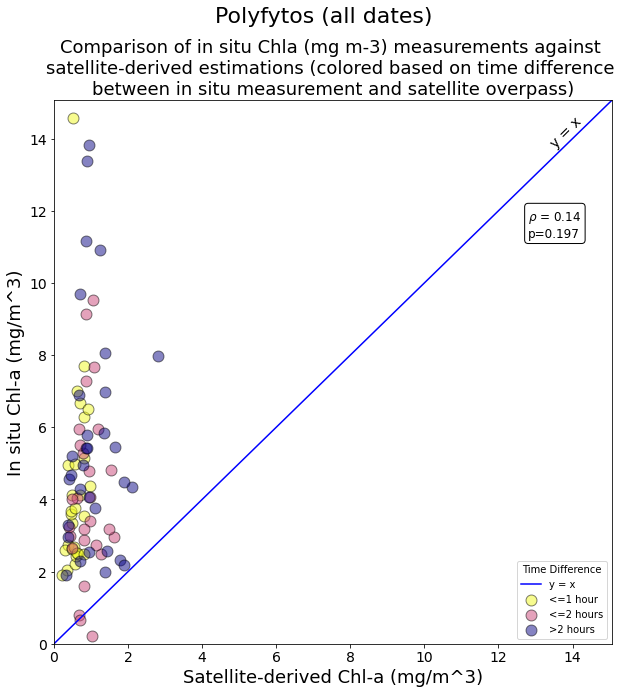

15.06484
TODO
plots/2025-09-30_144353/polyfytos_scatter_algae_all_uncB.jpg


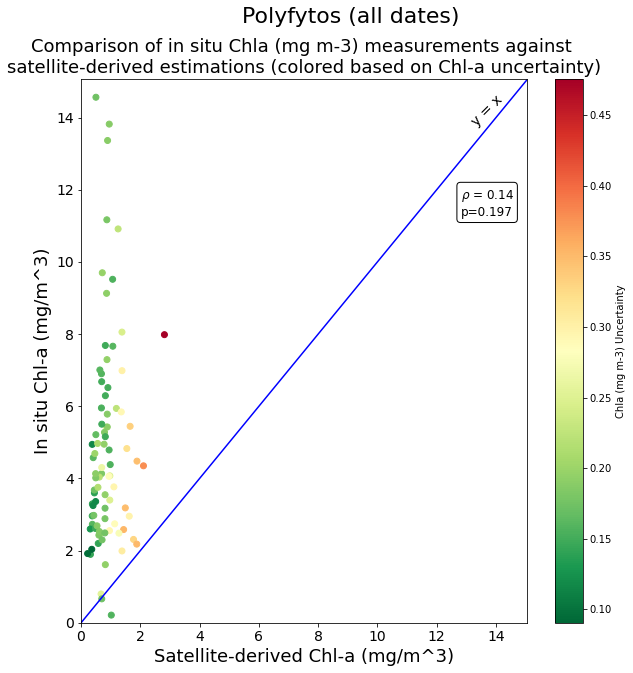

15.06484
This scatter plot of the absolute differences between in situ and satellite overpass against the time difference between in situ and the satellite image.
plots/2025-09-30_144353/polyfytos_scatter_algae_all_diff.jpg


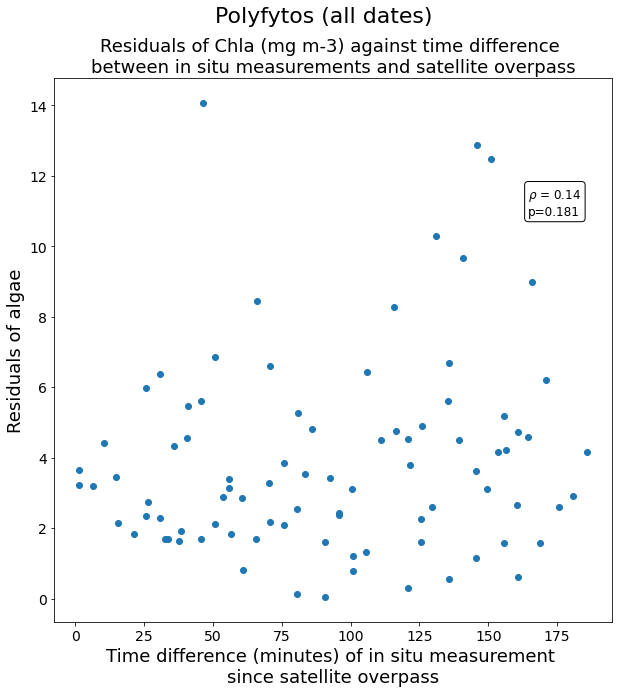

15.06484
TODO
plots/2025-09-30_144353/polyfytos_scatter_algae_all_uncRes.jpg


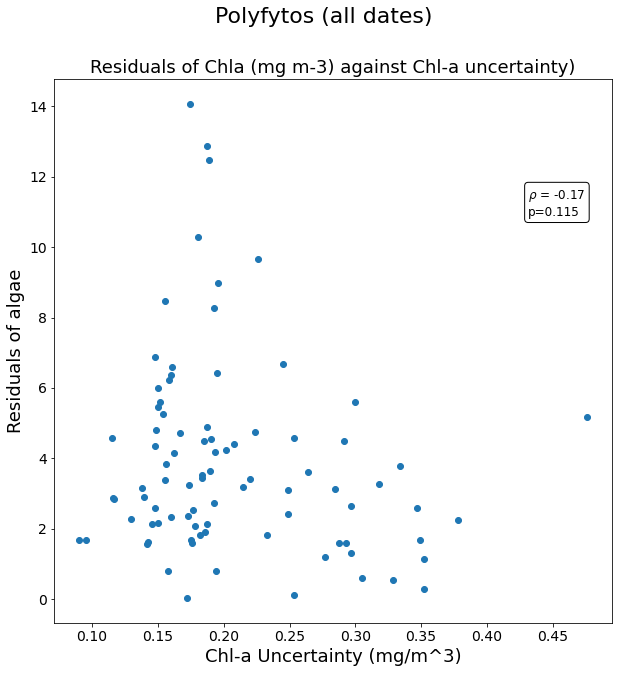

15.06484
This scatter plot of the absolute differences between in situ and satellite overpass against distance of the sample from the perimeter of the water body.
plots/2025-09-30_144353/polyfytos_scatter_algae_all_perim.jpg


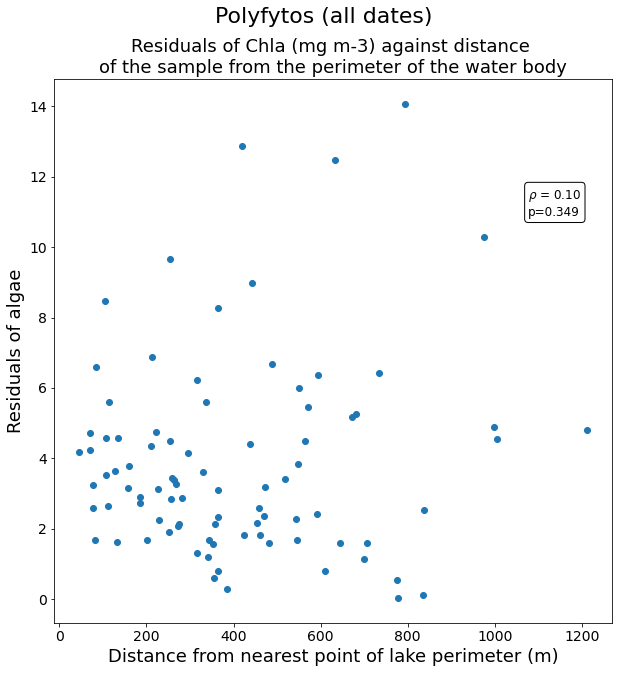

15.06484
This scatter plot of the the turbidity levels against the absolute differences between in situ and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_algae_all_aLt.jpg


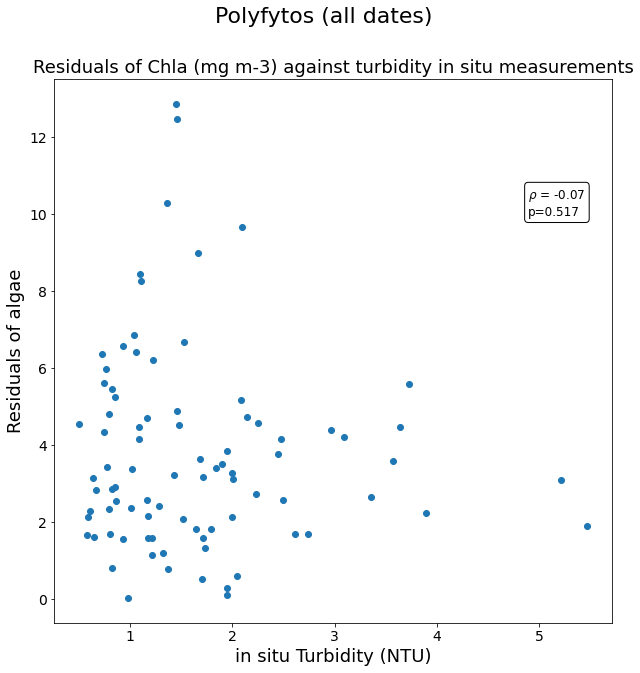

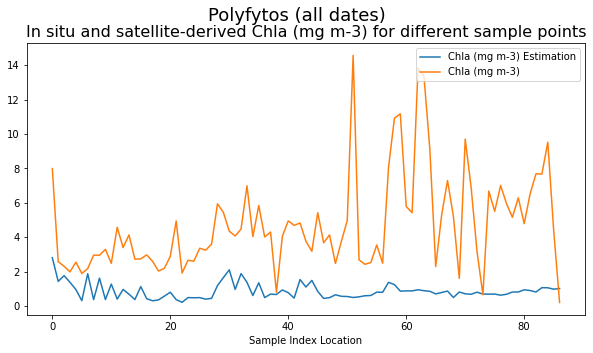

This scatter contains removed outliers.
5.96
This is the basic scatter plot
This scatter contains removed outliers.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_all_outlier.jpg


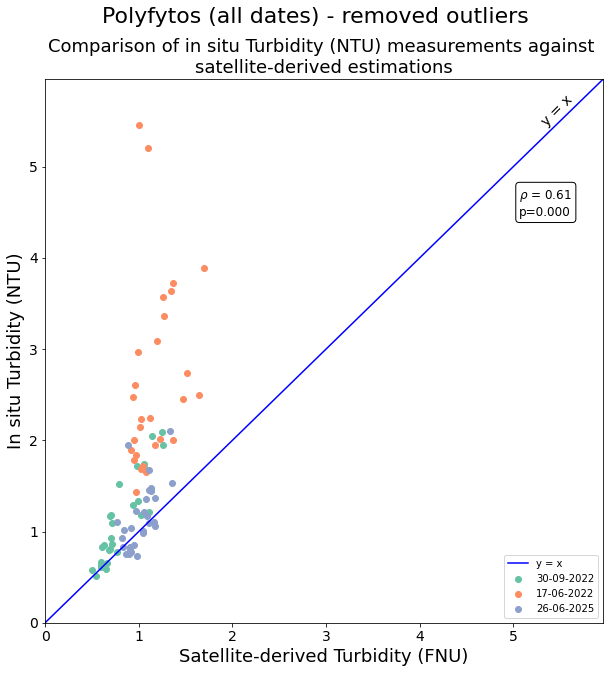

5.96
This scatter plot color-codes the samples depending on the time difference between in situ measurement and satellite overpass.
This scatter contains removed outliers.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_all_dtC_outlier.jpg


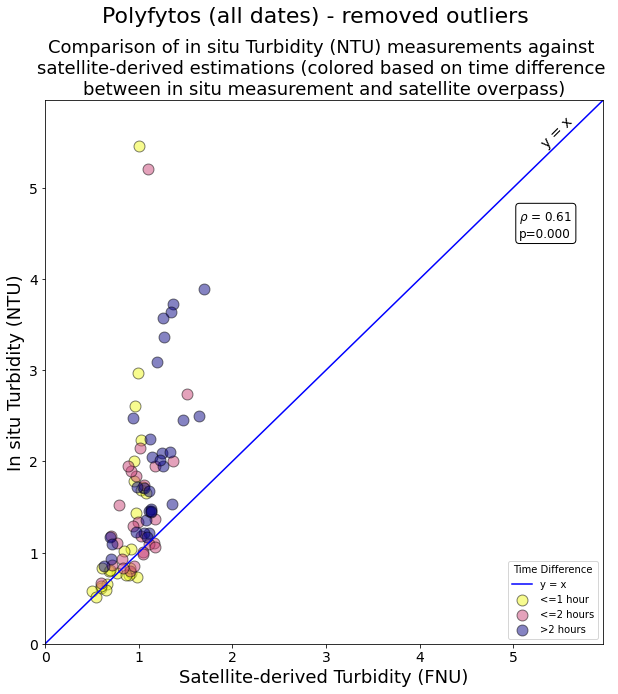

5.96
This scatter plot of the absolute differences between in situ and satellite overpass against the time difference between in situ and the satellite image.
This scatter contains removed outliers.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_all_diff_outlier.jpg


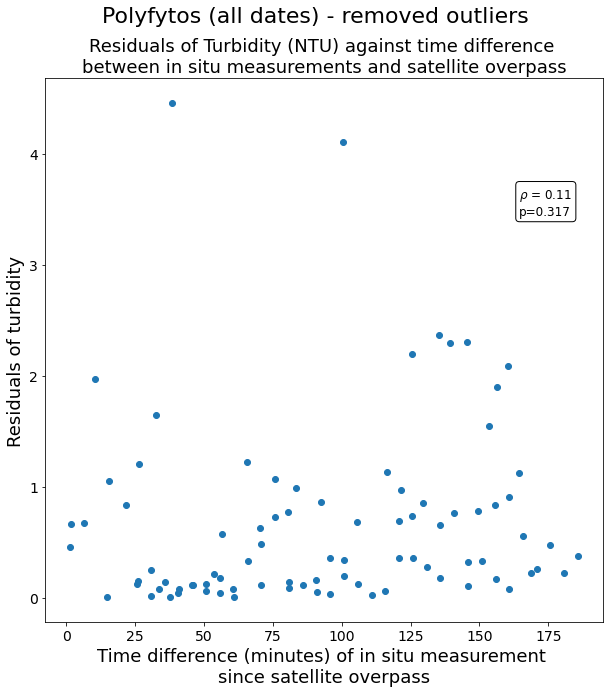

5.96
This scatter plot of the absolute differences between in situ and satellite overpass against distance of the sample from the perimeter of the water body.
This scatter contains removed outliers.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_all_perim_outlier.jpg


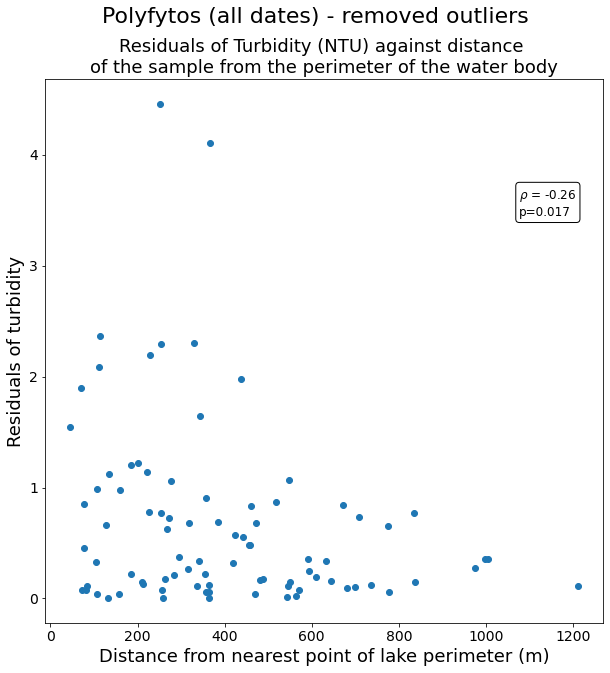

This scatter contains removed outliers.


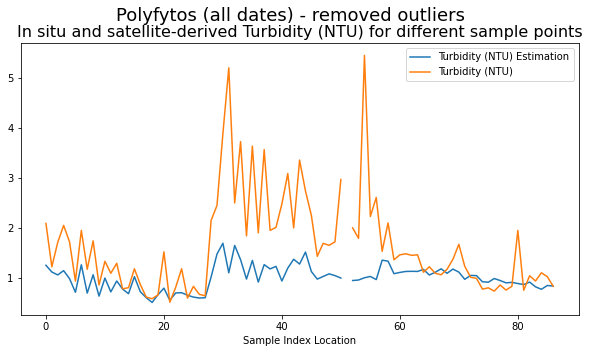

8.48536
This is the basic scatter plot
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-09-30.jpg


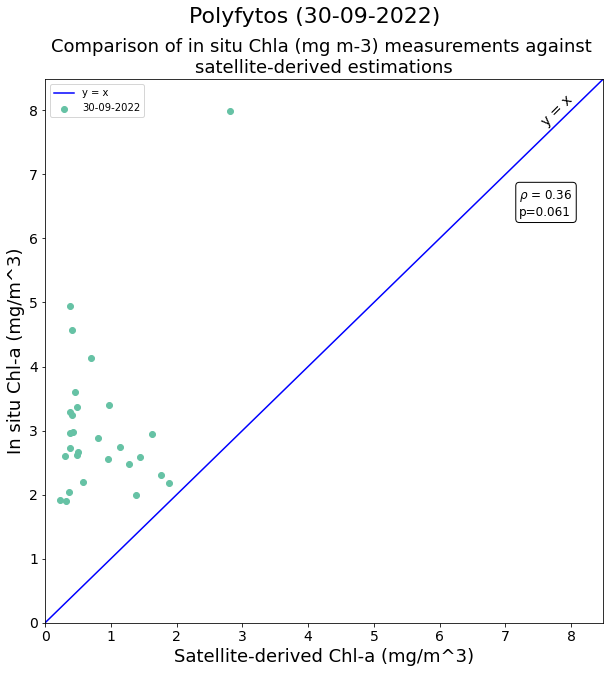

8.48536
This scatter plot color-codes the samples depending on the time difference between in situ measurement and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-09-30_dtC.jpg


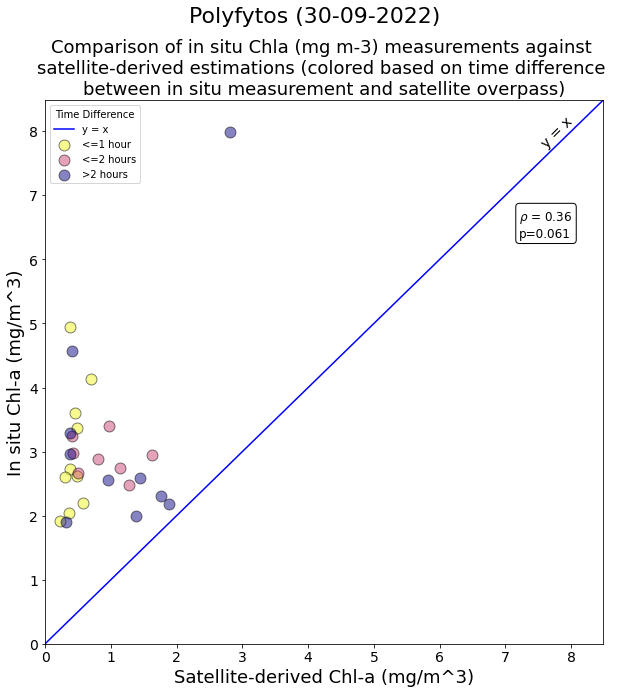

8.48536
TODO
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-09-30_uncB.jpg


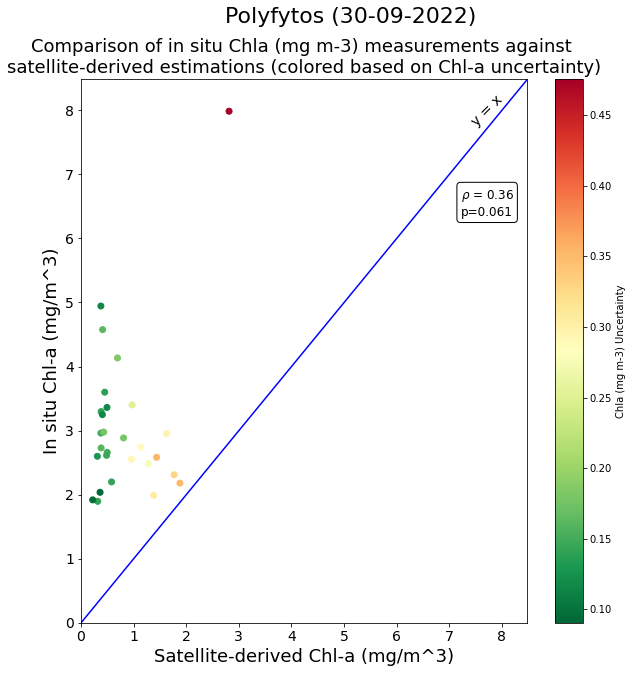

8.48536
This scatter plot of the absolute differences between in situ and satellite overpass against the time difference between in situ and the satellite image.
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-09-30_diff.jpg


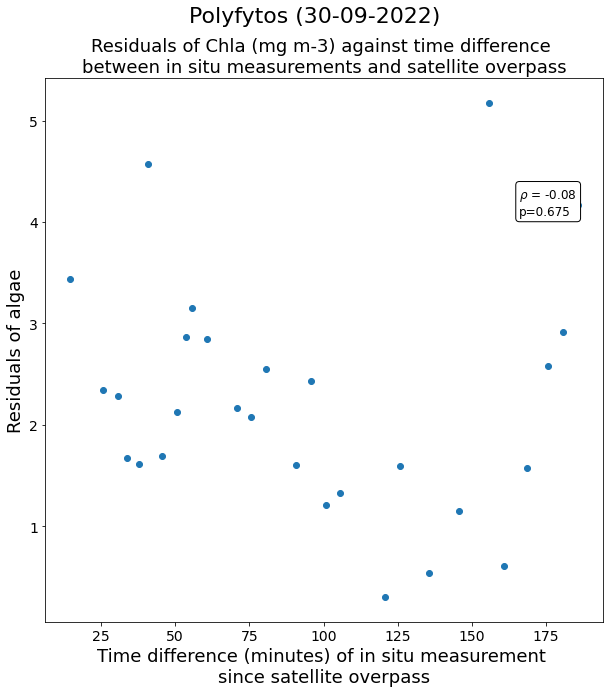

8.48536
TODO
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-09-30_uncRes.jpg


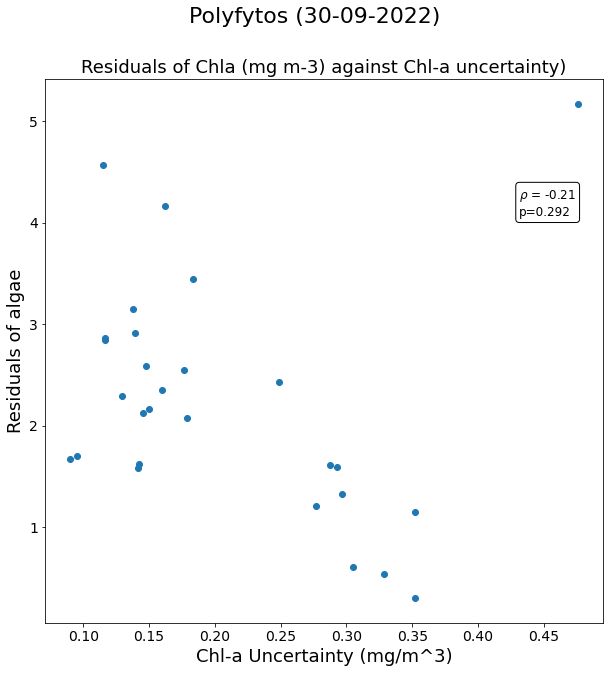

8.48536
This scatter plot of the absolute differences between in situ and satellite overpass against distance of the sample from the perimeter of the water body.
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-09-30_perim.jpg


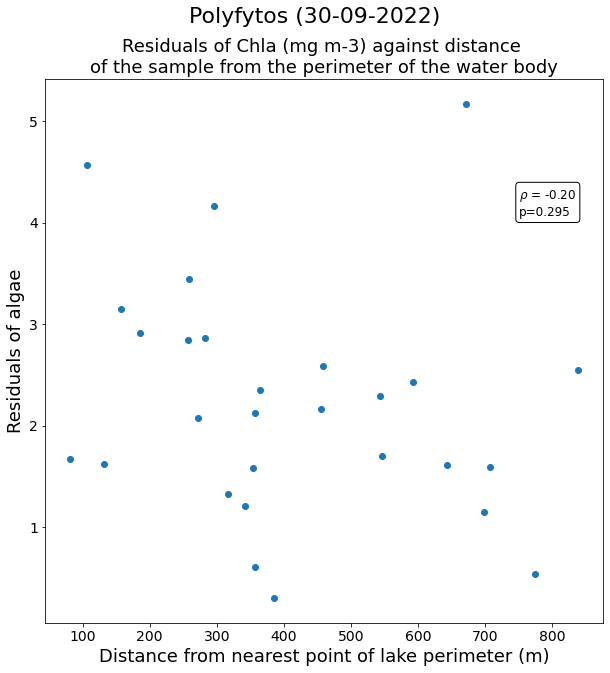

8.48536
This scatter plot of the the turbidity levels against the absolute differences between in situ and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-09-30_aLt.jpg


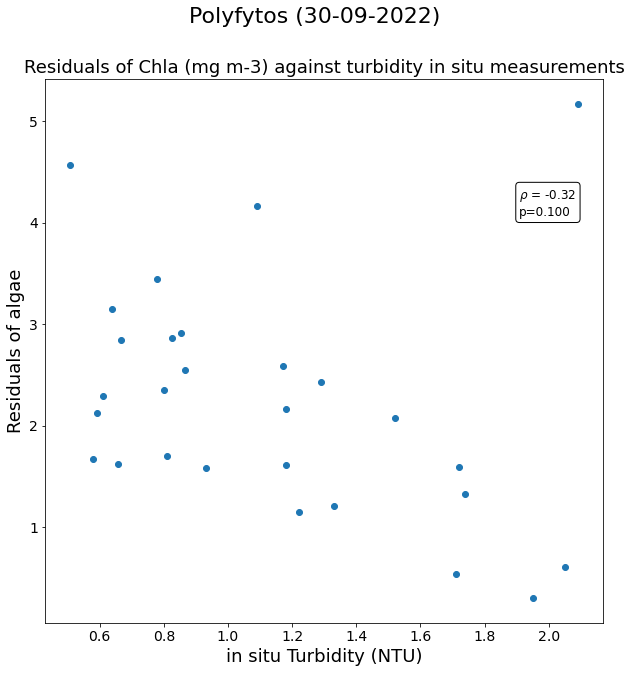

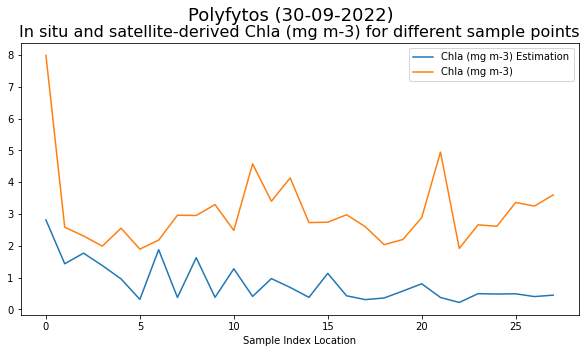

2.59
This is the basic scatter plot
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2022-09-30.jpg


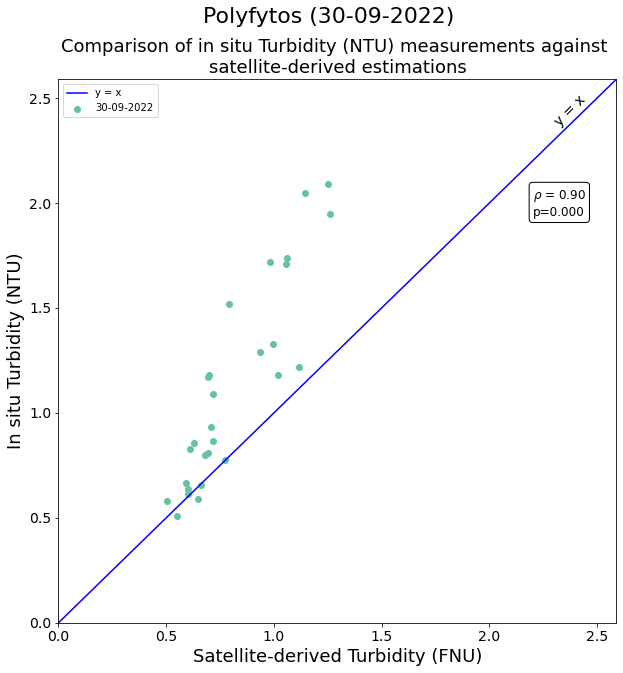

2.59
This scatter plot color-codes the samples depending on the time difference between in situ measurement and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2022-09-30_dtC.jpg


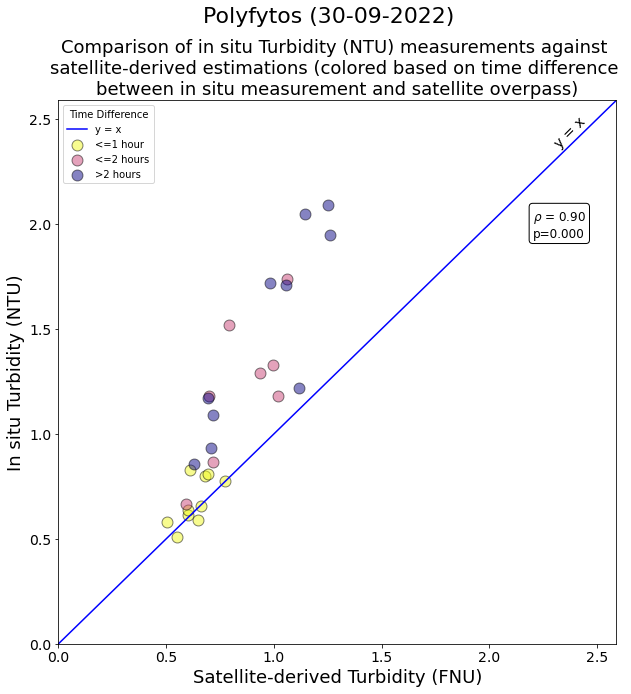

2.59
This scatter plot of the absolute differences between in situ and satellite overpass against the time difference between in situ and the satellite image.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2022-09-30_diff.jpg


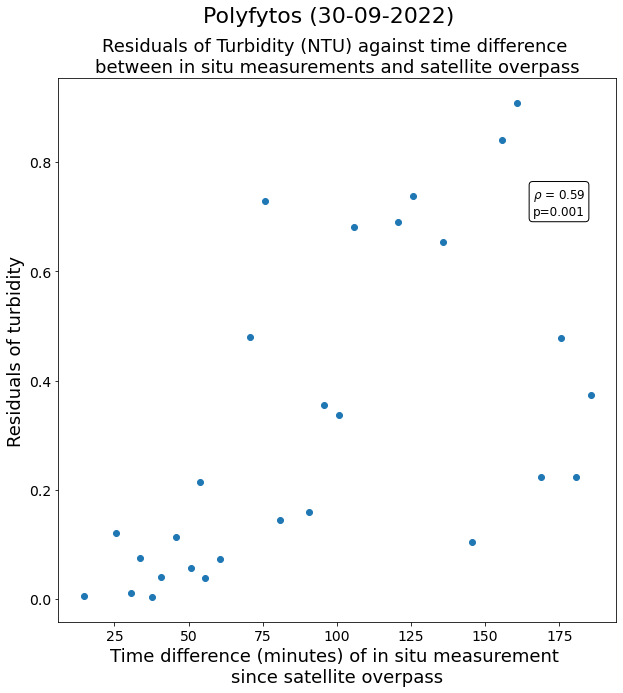

2.59
This scatter plot of the absolute differences between in situ and satellite overpass against distance of the sample from the perimeter of the water body.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2022-09-30_perim.jpg


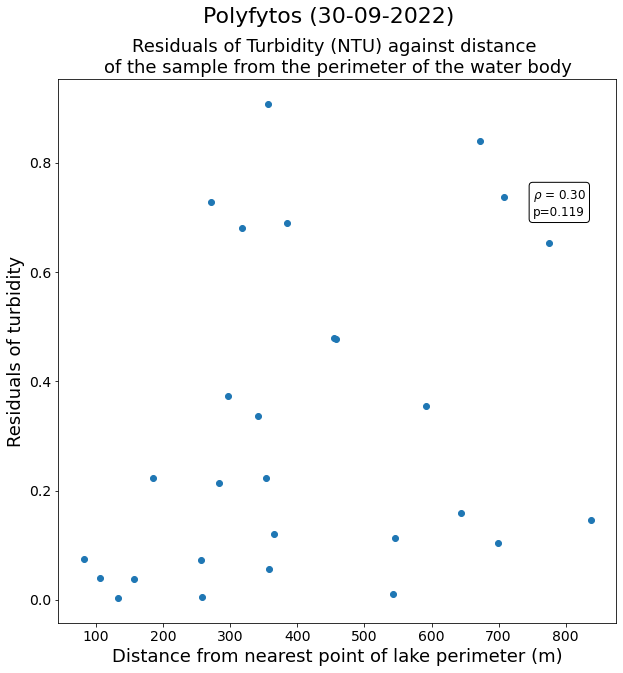

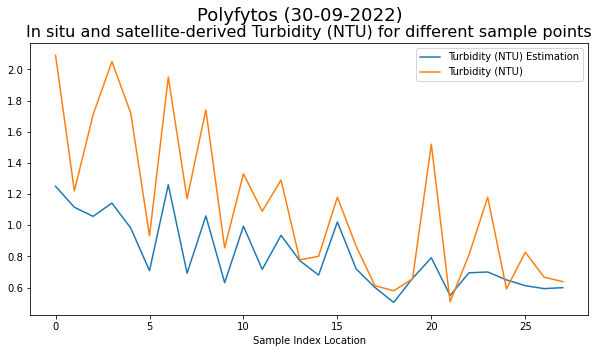

This scatter contains removed outliers.
15.06484
This is the basic scatter plot
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-06-17.jpg


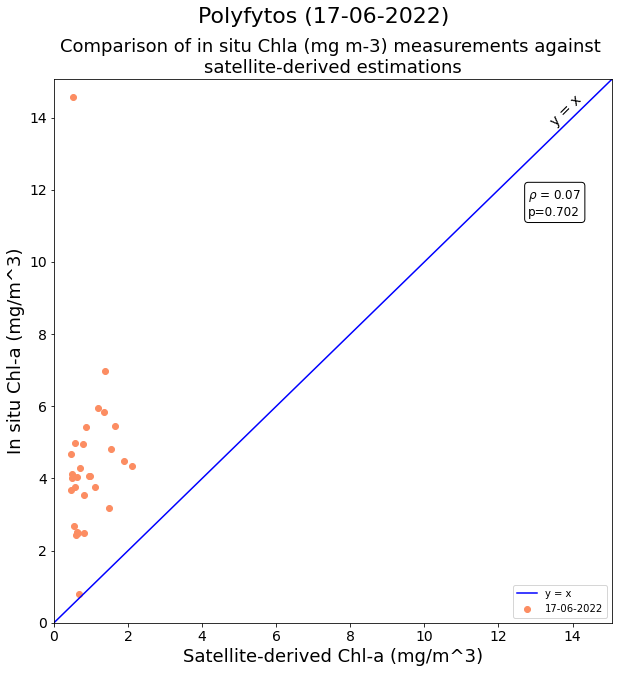

15.06484
This scatter plot color-codes the samples depending on the time difference between in situ measurement and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-06-17_dtC.jpg


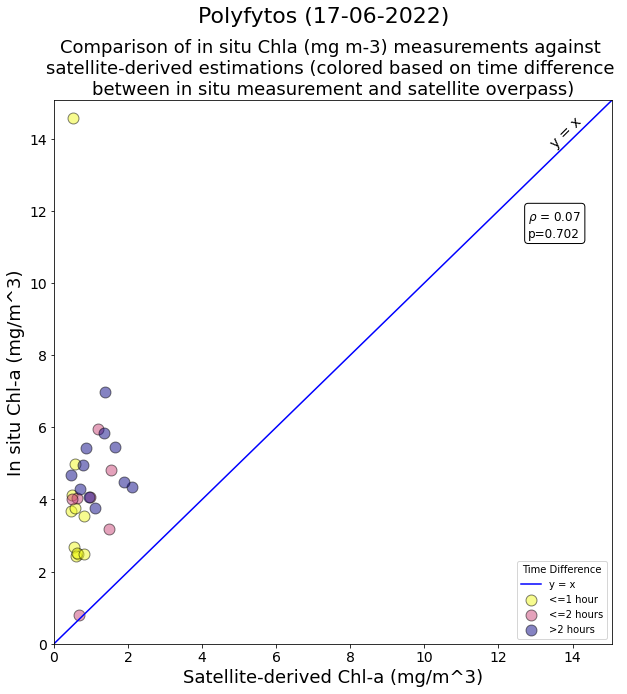

15.06484
TODO
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-06-17_uncB.jpg


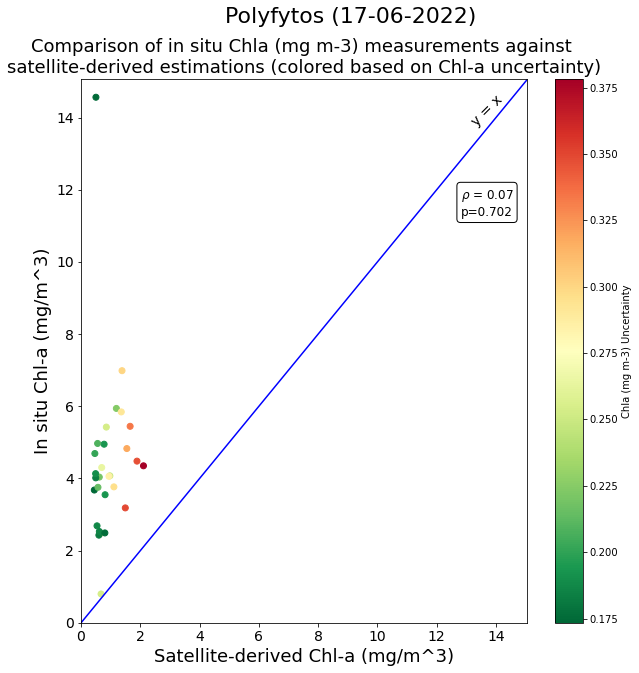

15.06484
This scatter plot of the absolute differences between in situ and satellite overpass against the time difference between in situ and the satellite image.
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-06-17_diff.jpg


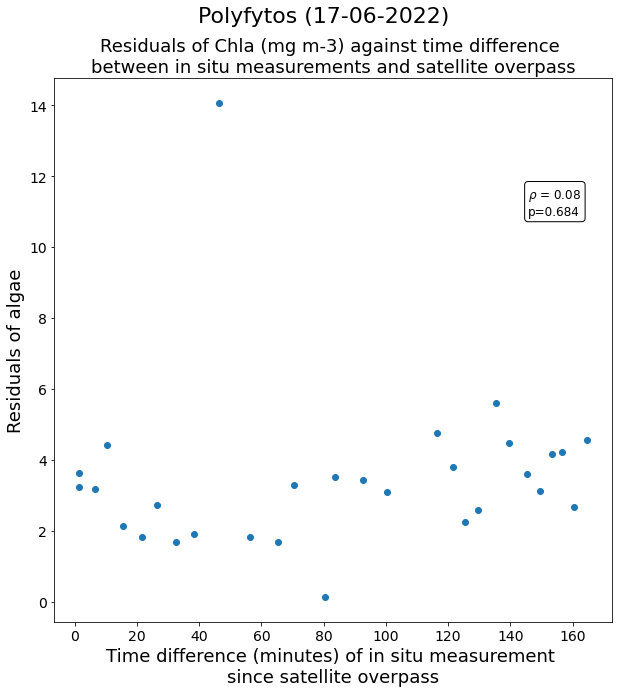

15.06484
TODO
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-06-17_uncRes.jpg


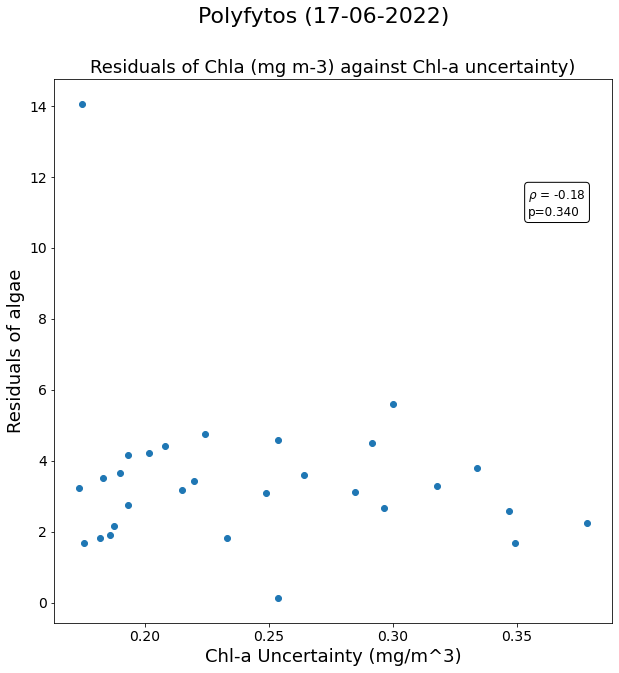

15.06484
This scatter plot of the absolute differences between in situ and satellite overpass against distance of the sample from the perimeter of the water body.
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-06-17_perim.jpg


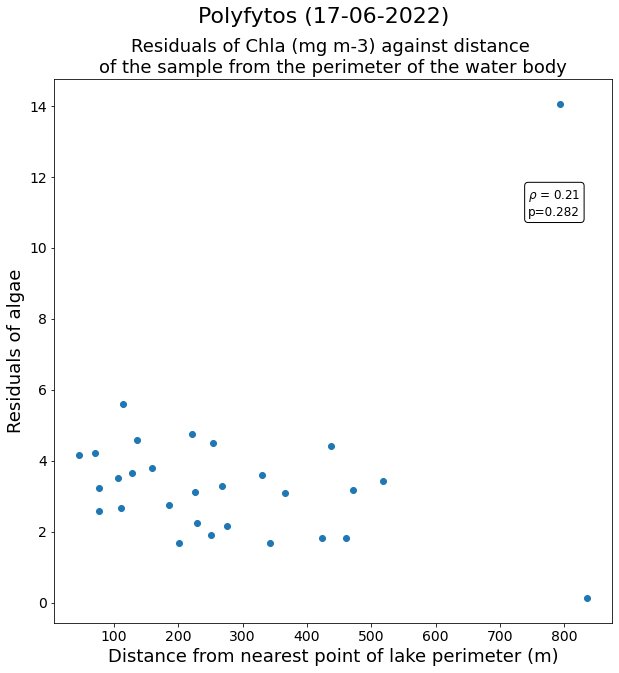

15.06484
This scatter plot of the the turbidity levels against the absolute differences between in situ and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_algae_2022-06-17_aLt.jpg


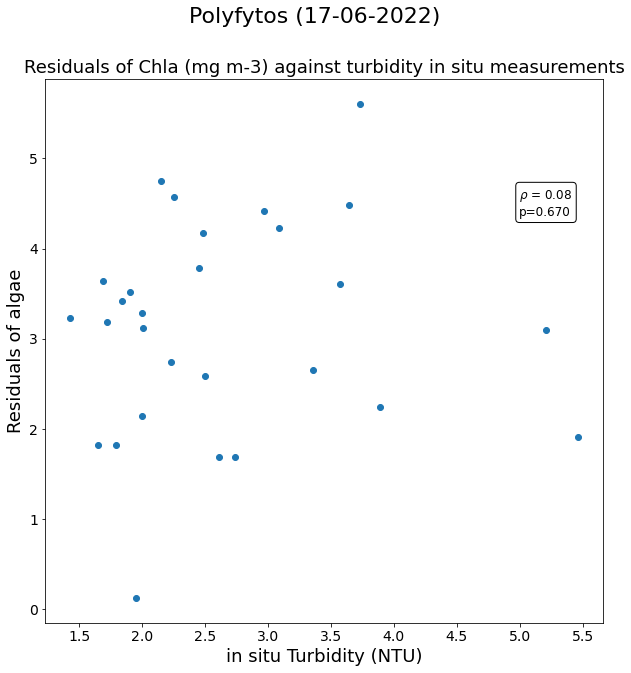

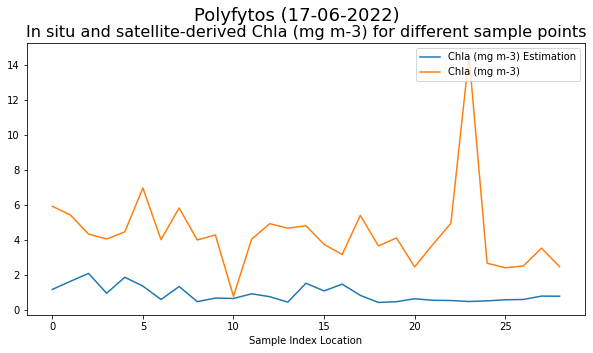

This scatter contains removed outliers.
5.96
This is the basic scatter plot
This scatter contains removed outliers.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2022-06-17_outlier.jpg


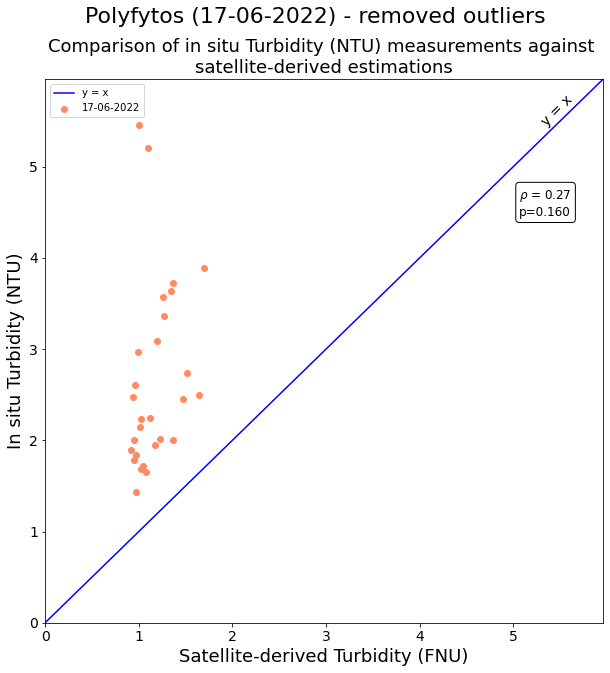

5.96
This scatter plot color-codes the samples depending on the time difference between in situ measurement and satellite overpass.
This scatter contains removed outliers.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2022-06-17_dtC_outlier.jpg


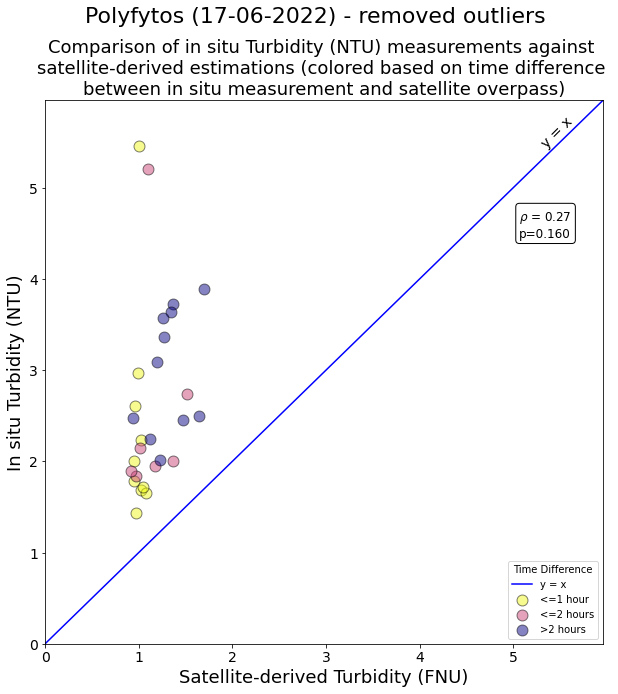

5.96
This scatter plot of the absolute differences between in situ and satellite overpass against the time difference between in situ and the satellite image.
This scatter contains removed outliers.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2022-06-17_diff_outlier.jpg


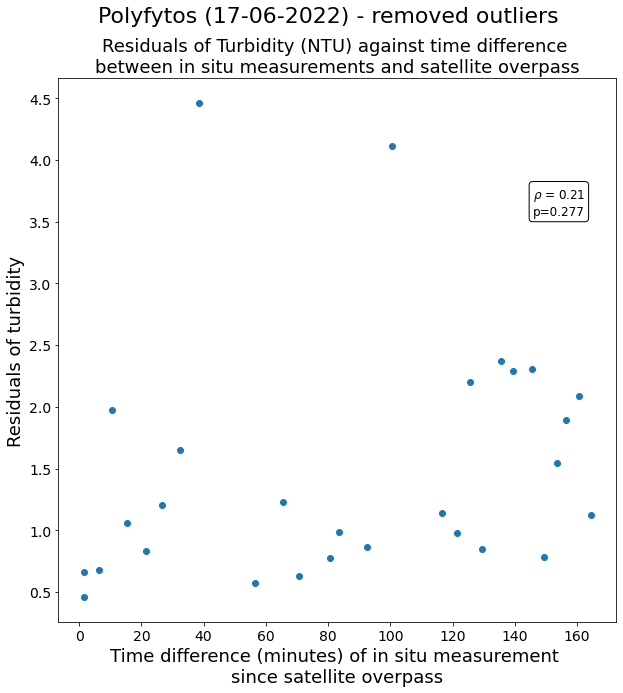

5.96
This scatter plot of the absolute differences between in situ and satellite overpass against distance of the sample from the perimeter of the water body.
This scatter contains removed outliers.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2022-06-17_perim_outlier.jpg


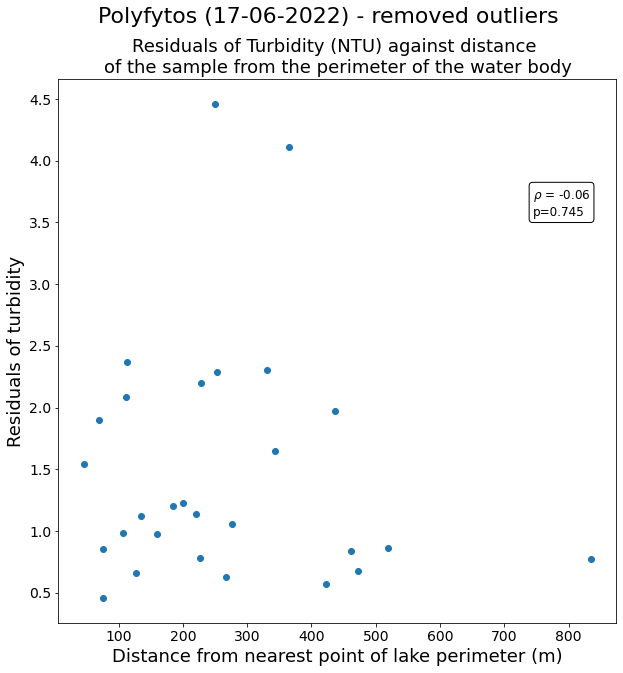

This scatter contains removed outliers.


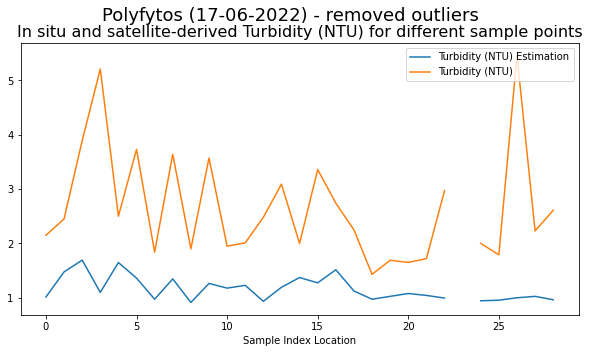

14.32038
This is the basic scatter plot
plots/2025-09-30_144353/polyfytos_scatter_algae_2025-06-26.jpg


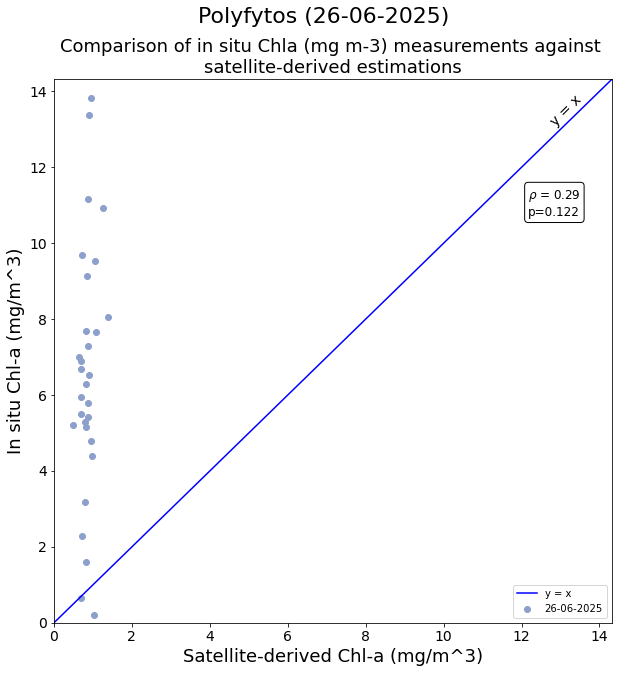

14.32038
This scatter plot color-codes the samples depending on the time difference between in situ measurement and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_algae_2025-06-26_dtC.jpg


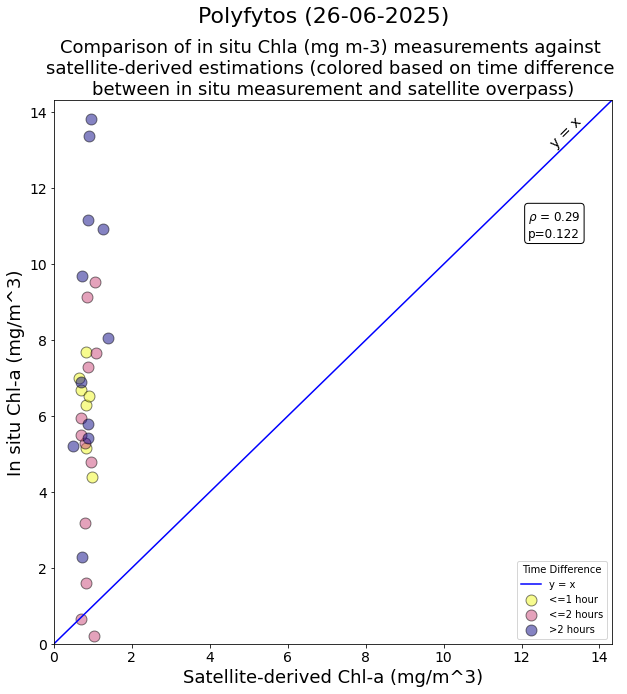

14.32038
TODO
plots/2025-09-30_144353/polyfytos_scatter_algae_2025-06-26_uncB.jpg


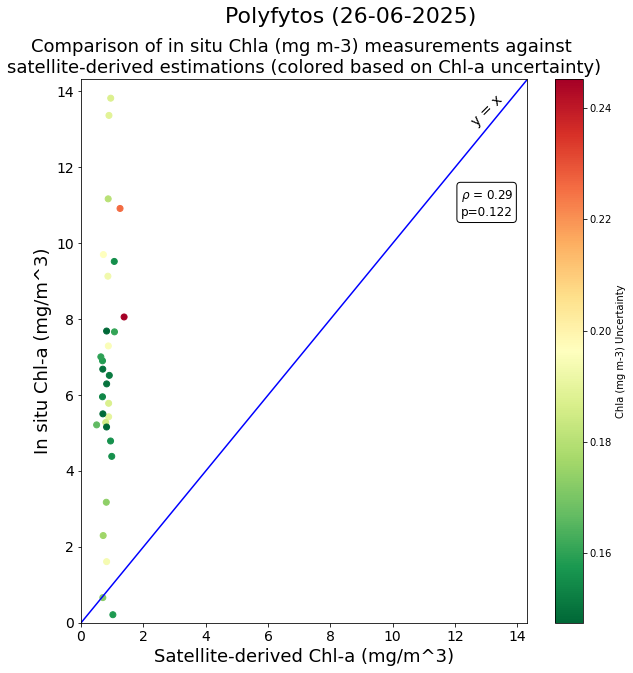

14.32038
This scatter plot of the absolute differences between in situ and satellite overpass against the time difference between in situ and the satellite image.
plots/2025-09-30_144353/polyfytos_scatter_algae_2025-06-26_diff.jpg


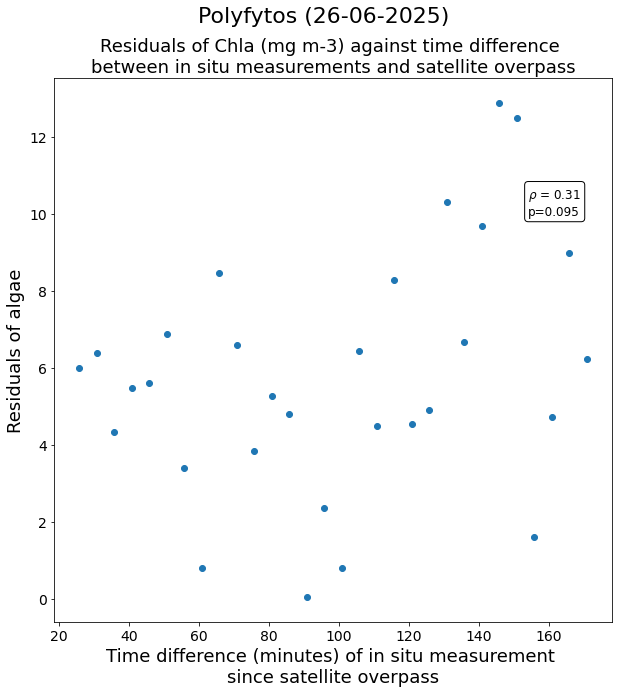

14.32038
TODO
plots/2025-09-30_144353/polyfytos_scatter_algae_2025-06-26_uncRes.jpg


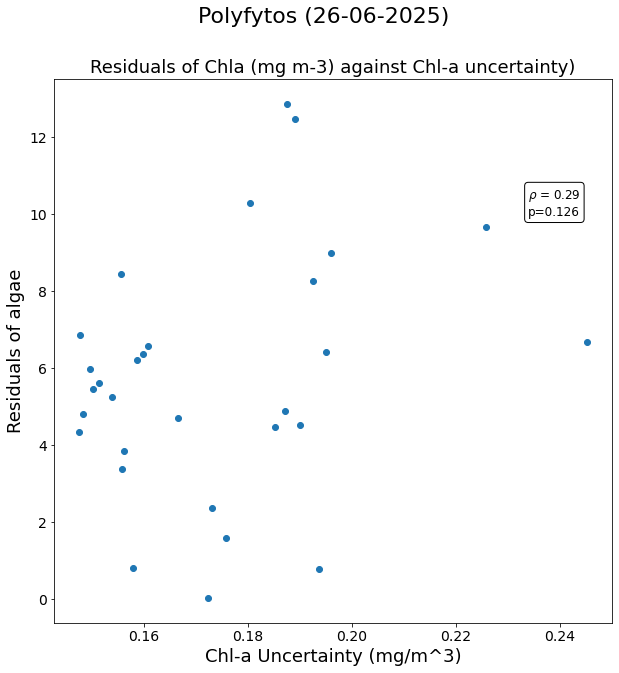

14.32038
This scatter plot of the absolute differences between in situ and satellite overpass against distance of the sample from the perimeter of the water body.
plots/2025-09-30_144353/polyfytos_scatter_algae_2025-06-26_perim.jpg


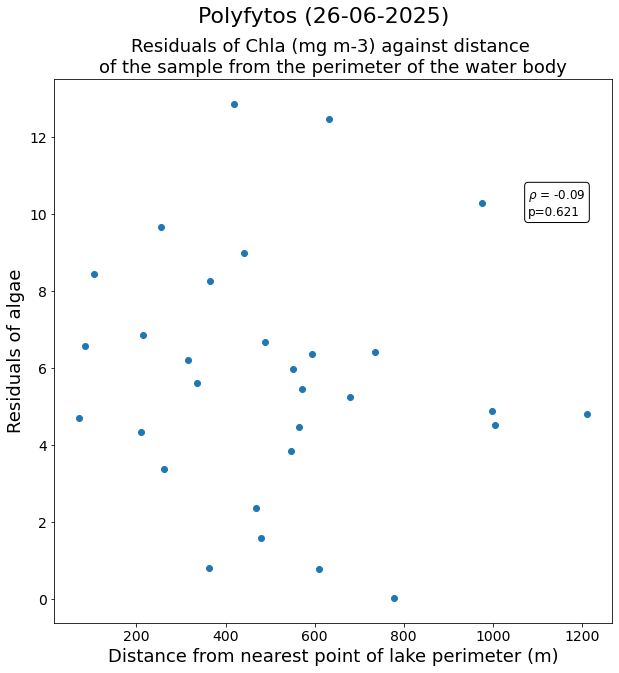

14.32038
This scatter plot of the the turbidity levels against the absolute differences between in situ and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_algae_2025-06-26_aLt.jpg


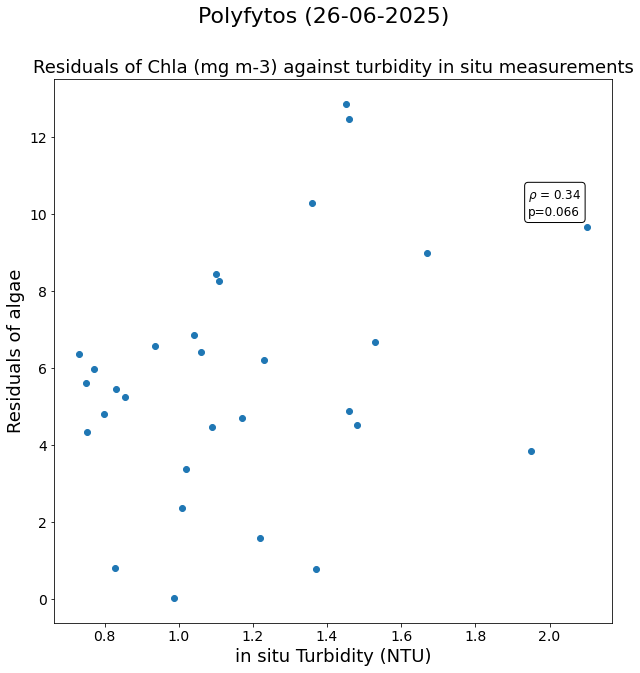

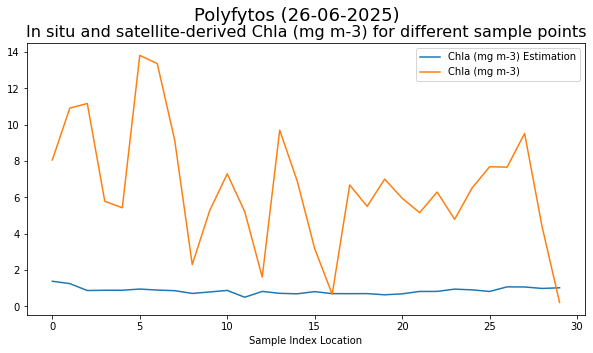

2.6
This is the basic scatter plot
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2025-06-26.jpg


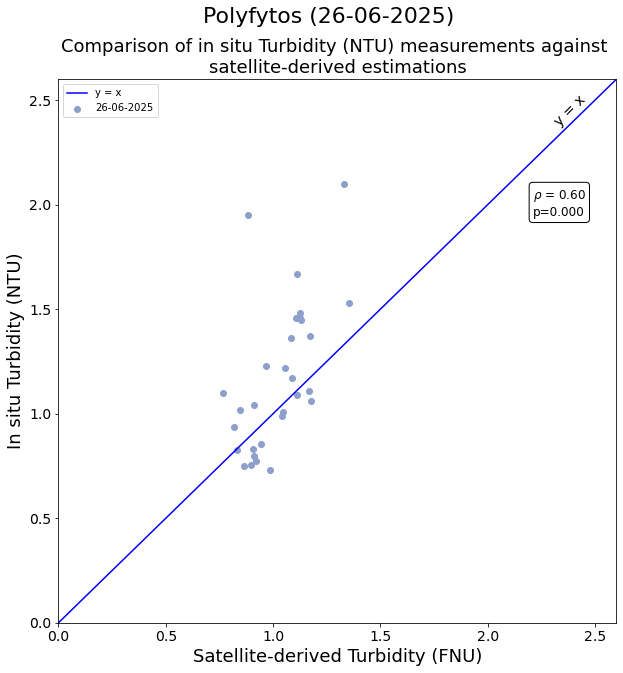

2.6
This scatter plot color-codes the samples depending on the time difference between in situ measurement and satellite overpass.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2025-06-26_dtC.jpg


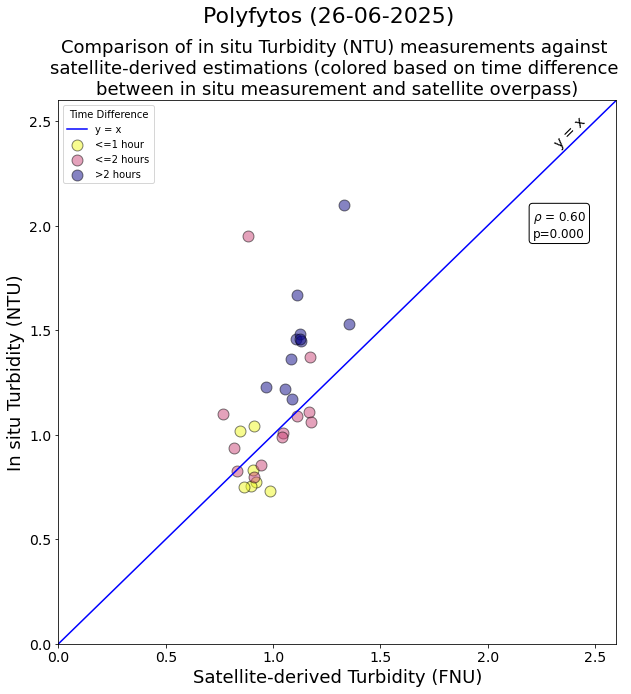

2.6
This scatter plot of the absolute differences between in situ and satellite overpass against the time difference between in situ and the satellite image.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2025-06-26_diff.jpg


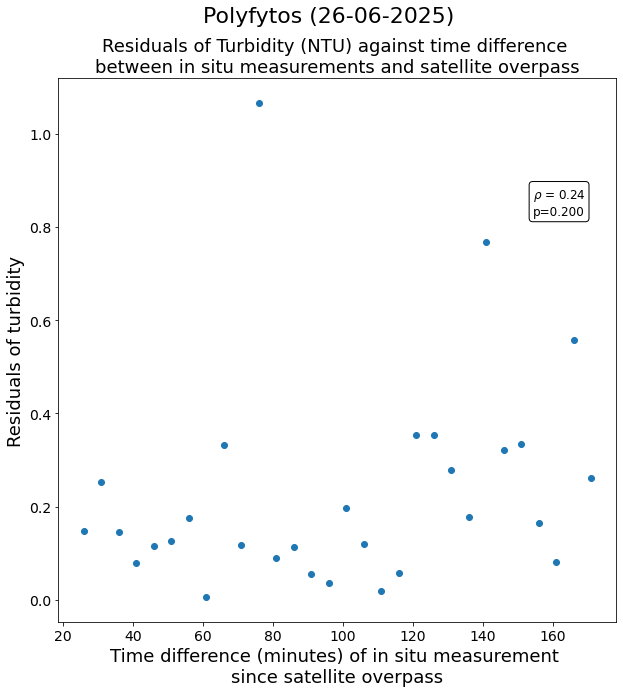

2.6
This scatter plot of the absolute differences between in situ and satellite overpass against distance of the sample from the perimeter of the water body.
plots/2025-09-30_144353/polyfytos_scatter_turbidity_2025-06-26_perim.jpg


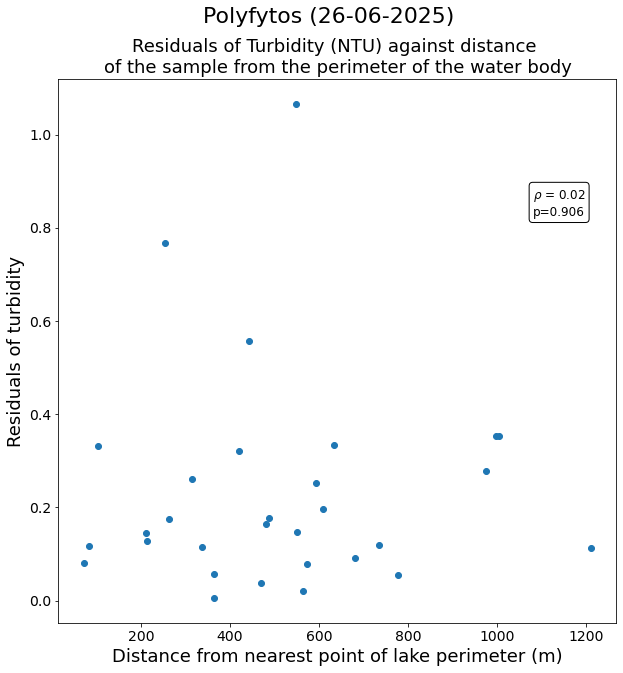

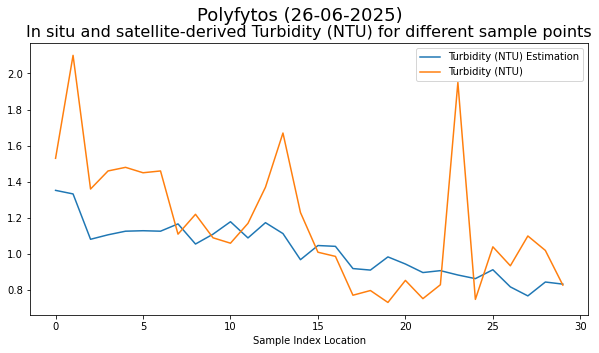

In [8]:
dates_fig = ["all", "2022-09-30", "2022-06-17", "2025-06-26"] # for which dates to create plots

ro = False # TODO: Make this functionality more robust
for date_sel in dates_fig:
    if (date_sel in ["all", "2022-06-17"]) and remove_outlier:
        ro = True
    # Save figures in a pdf
    if savepdf:
        pdf_name = f"Polyfytos_{date_sel}.pdf"
        if ro:
            name, ext = os.path.splitext(pdf_name)
            pdf_name = f"{name}_rem_outlier{ext}"
        
        pdf = PdfPages(os.path.join(fig_dir, pdf_name))
    else:
        pdf = None

    plotter = Plotter(gdf=gdfPlots, outputDir=fig_dir, pdf=pdf, savefig=True)
    
    # ALGAE
    plotter.add_text(feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=ro, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Basic Scatter Plot
    plotter.scatter(scatter_type=ScatterType.SIMPLE, feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=False, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Bubble Plot (Time Difference)
    plotter.scatter(scatter_type=ScatterType.TIME_DIFF_BUBBLE, feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=False, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Bubble Plot (Uncertainty)
    plotter.scatter(scatter_type=ScatterType.UNC_CHL_BUBBLE, feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=False, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Residuals against Time Difference
    plotter.scatter(scatter_type=ScatterType.RESIDUAL_AGAINST_TIME_DIFF, feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=False, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Residuals against Uncertainty Chl-a
    plotter.scatter(scatter_type=ScatterType.RESIDUAL_AGAINST_UNC_CHL, feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=False, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Residuals against Distance from Perimeter
    plotter.scatter(scatter_type=ScatterType.RESIDUAL_AGAINST_DIST_FROM_PERIM, feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=False, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Residuals (Chl-a) against Turbidity
    plotter.scatter(scatter_type=ScatterType.RESIDUAL_ALGAE_AGAINST_TURB, feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=False, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Line plots
    plotter.line_plot(feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=False, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    #plotter.scatter(scatter_type=ScatterType.OWT_VIOLION, feature='algae', date=date_sel, HAVE_REMOVED_OUTLIERS=False, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)

    # TURBIDITY
    plotter.add_text(feature='turbidity', date=date_sel, HAVE_REMOVED_OUTLIERS=ro, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Basic Scatter Plot
    plotter.scatter(scatter_type=ScatterType.SIMPLE, feature='turbidity', date=date_sel, HAVE_REMOVED_OUTLIERS=ro, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Bubble Plot (Time Difference)
    plotter.scatter(scatter_type=ScatterType.TIME_DIFF_BUBBLE, feature='turbidity', date=date_sel, HAVE_REMOVED_OUTLIERS=ro, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Residuals against Time Difference
    plotter.scatter(scatter_type=ScatterType.RESIDUAL_AGAINST_TIME_DIFF, feature='turbidity', date=date_sel, HAVE_REMOVED_OUTLIERS=ro, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Residuals against Distance from Perimeter
    plotter.scatter(scatter_type=ScatterType.RESIDUAL_AGAINST_DIST_FROM_PERIM, feature='turbidity', date=date_sel, HAVE_REMOVED_OUTLIERS=ro, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)
    # Line plots
    plotter.line_plot(feature='turbidity', date=date_sel, HAVE_REMOVED_OUTLIERS=ro, TIME_DIFF_LIMIT=TIME_DIFF_LIMIT)

    # Close pdf so it will be saved
    if savepdf:
        pdf.close()

    ro = False

# Inspect min/max values of GeoTiff

In [7]:
# Replace with your GeoTIFF path
geotiff_path = "./data/old/S2A_MSIL1C_20220930T092041_N0510_R093_T34TEK_20240725T230829_turbidity_monitorV2.tif"

with rasterio.open(geotiff_path) as src:
    for i in range(1, src.count + 1):  # Loop through each band
        band = src.read(i)
        # Mask out nodata values
        if src.nodata is not None:
            band = np.ma.masked_equal(band, src.nodata)

        min_val = band.min()
        max_val = band.max()
        print(f"Band {i}: Min = {min_val}, Max = {max_val}")

Band 1: Min = 0.23000000417232513, Max = 32.00030517578125
